# Cassava Leaf Disease Classification
Details: [kaggle.com](https://www.kaggle.com/c/cassava-leaf-disease-classification)

## Prepare kaggle dataset

In [1]:
!pip install -q kaggle
!wget -q https://github.com/MohammadRaziei/Deep-Learning-Course/raw/master/Project/kaggle/key/kaggle.json -O ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                    title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
gpreda/covid-world-vaccination-progress                COVID-19 World Vaccination Progress                  41KB  2021-02-01 08:48:19           5222  
ayushggarg/all-trumps-twitter-insults-20152021         All Trump's Twitter insults (2015-2021)             581KB  2021-01-20 16:51:05           1054  
sevgisarac/temperature-change                          Temperature change                                  778KB  2020-12-24 20:06:36           1146  
jorgesandoval/wind-power-generation                    Wind Power Generation Data                          245KB  2021-01-07 18:45:08            459  
cdminix/us-drought-meteorological-data                 US Drought & Meteorological Data       

In [24]:
!mkdir -p Dataset
!kaggle competitions download -c cassava-leaf-disease-classification --path Dataset

  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 40.2MB/s]
 97% 211M/217M [00:08<00:00, 17.2MB/s]
100% 217M/217M [00:08<00:00, 25.7MB/s]
 98% 214M/218M [00:08<00:00, 29.7MB/s]
100% 218M/218M [00:09<00:00, 23.3MB/s]
 95% 205M/216M [00:01<00:00, 152MB/s]
100% 216M/216M [00:01<00:00, 156MB/s]
 90% 196M/217M [00:01<00:00, 147MB/s]
100% 217M/217M [00:01<00:00, 154MB/s]
 92% 198M/216M [00:01<00:00, 119MB/s] 
100% 216M/216M [00:01<00:00, 128MB/s]
 96% 209M/217M [00:09<00:00, 17.9MB/s]
100% 217M/217M [00:09<00:00, 23.8MB/s]
 96% 205M/214M [00:09<00:00, 15.8MB/s]
100% 214M/214M [00:09<00:00, 24.1MB/s]
 94% 202M/216M [00:01<00:00, 117MB/s] 
100% 216M/216M [00:01<00:00, 124MB/s]
 96% 209M/217M [00:08<00:00, 20.8MB/s]
100% 217M/217M [00:08<00:00, 27.4MB/s]
 99% 214M/217M [00:08<00:00, 29.0MB/s]
100% 217M/217M [00:08<00:00, 26.2MB/s]
 97% 209M/216M [00:08<00:00, 16.8MB/s]
100% 216M/216M [00:08<00:00, 25.4MB/s]
 91% 196M/216M [00:01<00:00, 96.5MB/s]
100% 216M/216M [00:01<00:00, 115MB/s] 


In [17]:
import zipfile
import shutil, pathlib
from tqdm.auto import tqdm

def unzip_file(filename, target_path='.'):
  zf = zipfile.ZipFile(filename, 'r')
  zf.extractall(target_path)
  zf.close()

def unzip_files(filename_list, target_path='.'):
  for filename in tqdm(zip_files):
    unzip_file(filename, target_path)

def create_path(path):
  pathlib.Path(path).mkdir(parents=True, exist_ok=True)

def remove_path(path):
  shutil.rmtree(path, ignore_errors=True)

def recreate_path(path):
  remove_path(path)
  create_path(path)

In [23]:
import glob
zip_files = glob.glob('Dataset/*.zip')
unzip_files(zip_files, target_path='Dataset')

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


def resize_image(image, target_size=(100,100)):
    img = Image.fromarray(image)
    img = img.resize(target_size, Image.ANTIALIAS)
    img = np.asarray(img)
    return img

""" 
I recommend to see following websites:
  * https://stepup.ai/exploring_data_augmentation_keras/
  * https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/
"""
# create generator
datagen = ImageDataGenerator()
train_it = datagen.flow_from_directory('data/train/', class_mode='binary')
val_it = datagen.flow_from_directory('data/validation/', class_mode='binary')
test_it = datagen.flow_from_directory('data/test/', class_mode='binary')



In [24]:
# FILENAMES = tf.io.gfile.glob("Dataset/ld_train*.tfrec")
FILENAMES = tf.io.gfile.glob("Dataset/ld_train*1327.tfrec")


In [55]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "gs://kds-b38ce1b823c3ae623f5691483dbaa0f0363f04b0d6a90b63cf69946e"
BATCH_SIZE = 64
IMAGE_SIZE = [512, 512]

In [56]:
from functools import partial

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example, labeled):
    tfrecord_format = (
        {
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else {"image": tf.io.FixedLenFeature([], tf.string),}
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example["image"])
    if labeled:
        label = tf.cast(example["target"], tf.int32)
        return image, label
    return image

def load_dataset(filenames, labeled=True):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(
        filenames
    )  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(
        ignore_order
    )  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True):
    dataset = load_dataset(filenames, labeled=labeled)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset



In [57]:

train_dataset = get_dataset(FILENAMES)


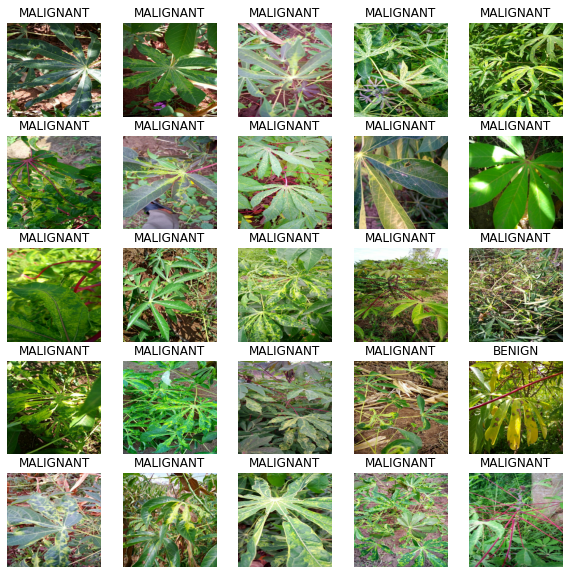

In [60]:
image_batch, label_batch = next(iter(train_dataset))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        if label_batch[n]:
            plt.title("MALIGNANT")
        else:
            plt.title("BENIGN")
        plt.axis("off")


show_batch(image_batch.numpy(), label_batch.numpy())

In [59]:
image_batch.shape

TensorShape([64, 512, 512, 3])

In [54]:
np.sqrt(786432/3)

512.0

In [47]:
list(train_dataset.as_numpy_iterator())

InvalidArgumentError: ignored

In [5]:
data=tf.data.TFRecordDataset(filenames = ['Dataset/ld_train00-1338.tfrec'])

In [22]:
import os
data_path = "Dataset/"
train_csv_data_path  = os.path.join(data_path, "train.csv")
label_json_data_path = os.path.join(data_path, "label_num_to_disease_map.json")
images_dir_data_path = os.path.join(data_path, "train_images")

In [13]:
import pandas as pd
train_csv = pd.read_csv(train_csv_data_path)
train_csv['label'] = train_csv['label'].astype('string')

label_class = pd.read_json(label_json_data_path, orient='index')
label_class = label_class.values.flatten().tolist()

In [15]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [16]:
print("Label names :")
for i, label in enumerate(label_class):
    print(f" {i}. {label}")

Label names :
 0. Cassava Bacterial Blight (CBB)
 1. Cassava Brown Streak Disease (CBSD)
 2. Cassava Green Mottle (CGM)
 3. Cassava Mosaic Disease (CMD)
 4. Healthy


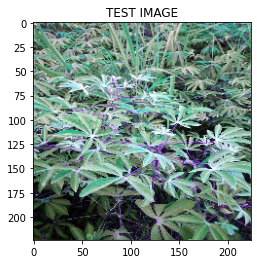

In [21]:
import matplotlib.pyplot as plt
import cv2
BATCH_SIZE = 18
IMG_SIZE = 224

test_img_path = os.path.join(data_path,"2216849948.jpg")

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)).reshape(-1, IMG_SIZE, IMG_SIZE, 3)/255

plt.figure(figsize=(8,4))
plt.title("TEST IMAGE")
plt.imshow(resized_img[0])
plt.show()

In [ ]:
preds = []
ss = pd.read_csv(data_path+'sample_submission.csv')

for image in ss.image_id:
    img = tf.keras.preprocessing.image.load_img(data_path+'test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = model_model.predict(img/255)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
my_submission.to_csv('submission.csv', index=False)

In [10]:
raw_example = next(iter(data))


In [11]:
raw_example

<tf.Tensor: shape=(), dtype=string, numpy=b'\n\x99\xc4\x0b\n\x0f\n\x06target\x12\x05\x1a\x03\n\x01\x00\n \n\nimage_name\x12\x12\n\x10\n\x0e1000015157.jpg\n\xe2\xc3\x0b\n\x05image\x12\xd7\xc3\x0b\n\xd3\xc3\x0b\n\xcf\xc3\x0b\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc0\x00\x11\x08\x02\x00\x02\x00\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x01\x05\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x06\x03\x04\x05\x07\x08\t\x02\x01\x00\n\xff\xc4\x00L\x10\x00\x01\x03\x03\x03\x02\x04\x04\x05\x02\x03\x06\x03\x07\x00\x0b\x01\x02\x03\x04\